## Codigo principal para el mecanismo de Laplace

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
import folium
def mecanismo_laplace_coordenadas(trayectoria, epsilon, semilla=None):
    """
    Aplica el Mecanismo de Laplace  punto a punto sobre una trayectoria en R^2.
    
    Parámetros:
        trayectoria: array-like de forma (n, 2). Puntos (x1, x2) de la trayectoria original.
        epsilon: float > 0. Presupuesto de privacidad (parámetro de escala del Laplaciano).
        semilla: int o None. Semilla opcional para reproducibilidad.
        
    Retorna:
        np.ndarray de forma (n, 2) con la trayectoria perturbada.
    """
    # (Chequeo) Aseguramos que epsilon > 0, como asume el mecanismo.
    if epsilon <= 0:
        raise ValueError("epsilon debe ser > 0")
    
    # Generador de números aleatorios, opcionalmente con semilla para reproducibilidad.
    rng = np.random.default_rng(semilla)
    
    # Lista para acumular los puntos perturbados.
    puntos_perturbados = []
    
    # Recorremos cada punto x de la trayectoria original.
    for x1, x2 in np.asarray(trayectoria):
        # ------------------------------- Paso 1: Ángulo -------------------------------
        # Según (6), en coordenadas polares centradas en x, la densidad se factoriza:
        #   D_e(r, θ) = (1 / 2π) * (ε^2 * r * e^{-ε r})
        # De ahí se desprende que θ ~ Uniforme(0, 2π). (independencia de r y θ)
        theta = rng.uniform(0.0, 2.0 * np.pi)
        
        # ------------------------------- Paso 2: Radio --------------------------------
        p = rng.uniform(0.0, 1.0)
        r = - (lambertw((p - 1.0) / np.e, k=-1).real + 1.0) / epsilon
        
        # ------------------------------- Paso 3: Cartesiano ---------------------------
        # Con (r, θ) obtenidos, transformamos a cartesianas alrededor de x:
        #   z = x + (r cos θ, r sin θ)   (ver pseudocódigo del paper)
        z1 = x1 + r * np.cos(theta)
        z2 = x2 + r * np.sin(theta)
        
        # Acumulamos el punto perturbado.
        puntos_perturbados.append((z1, z2))
    
    # Devolvemos como arreglo NumPy.
    return np.array(puntos_perturbados)

def cargar_trayectoria_real(ruta_archivo: str):
    """Carga trayectoria desde archivo PLT de GeoLife"""
    latlons = []
    with open(ruta_archivo, "r", encoding="utf-8", errors="ignore") as f:
        for i, linea in enumerate(f):
            if i < 6: continue  # Saltar cabecera
            partes = linea.strip().split(",")
            try:
                latlons.append((float(partes[0]), float(partes[1])))
            except (ValueError, IndexError):
                continue
    return latlons
def latlon_to_local_xy(lat, lon, lat0, lon0):
    lat = np.radians(lat)
    lon = np.radians(lon)
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    x = (lon - lon0) * np.cos(lat0) * R
    y = (lat - lat0) * R
    return x, y

def local_xy_to_latlon(x, y, lat0, lon0):
    lat0_rad = np.radians(lat0)
    lon0_rad = np.radians(lon0)
    lat = y / R + lat0_rad
    lon = x / (R * np.cos(lat0_rad)) + lon0_rad
    return np.degrees(lat), np.degrees(lon)

In [2]:
import numpy as np
from scipy.special import lambertw

def ejemplo_ilustrativo():
    x = np.array([0.0, 0.0])
    epsilon = 1.0
    
    # Fijamos los valores del ejemplo
    theta = np.pi / 4   # 45°
    p = 0.5
    
    # Radio con Lambert W
    r = - (lambertw((p - 1.0) / np.e, k=-1).real + 1.0) / epsilon
    
    # Coordenadas cartesianas
    z1 = x[0] + r * np.cos(theta)
    z2 = x[1] + r * np.sin(theta)
    
    return r, (z1, z2)

r, z = ejemplo_ilustrativo()
print("r =", r)
print("z =", z)


r = 1.6783469900166605
z = (np.float64(1.1867705378248115), np.float64(1.1867705378248115))


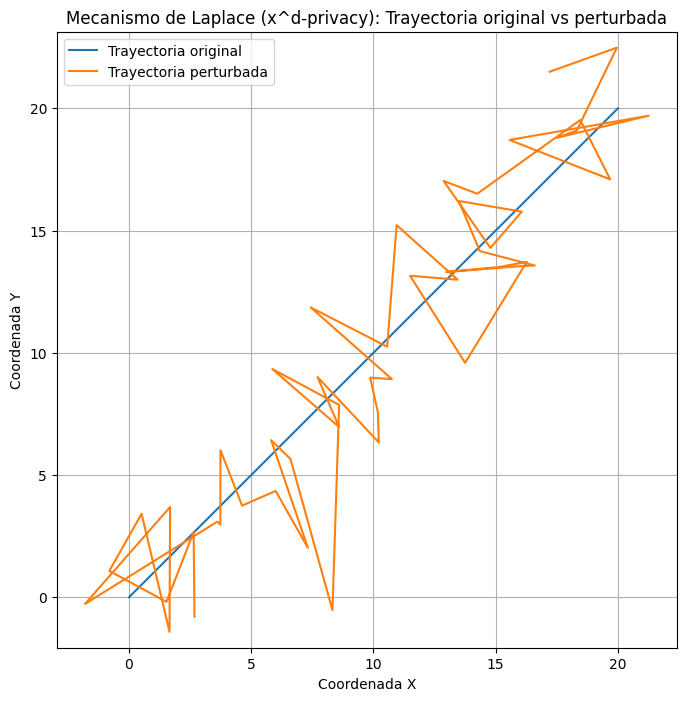

In [3]:
# ------------------------------- Ejemplo reproducible -------------------------------
# Trayectoria original: línea recta desde (0,0) hasta (20,20) con N puntos.
N = 50
trayectoria_original = np.linspace((0.0, 0.0), (20.0, 20.0), N)

# Presupuesto de privacidad (ε > 0).
epsilon = 1

# Aplicamos el mecanismo con semilla para reproducibilidad del ejemplo.
trayectoria_perturbada = mecanismo_laplace_coordenadas(
    trayectoria_original, epsilon=epsilon, semilla=41
)

# ------------------------------- Gráfica: Original vs Perturbada --------------------
plt.figure(figsize=(8, 8))
 
plt.plot(trayectoria_original[:, 0], trayectoria_original[:, 1], label="Trayectoria original")
plt.plot(trayectoria_perturbada[:, 0], trayectoria_perturbada[:, 1], label="Trayectoria perturbada")
plt.xlabel("Coordenada X")
plt.ylabel("Coordenada Y")
plt.title("Mecanismo de Laplace (x^d-privacy): Trayectoria original vs perturbada")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

## Grafica dos trayectorias en mapa

In [12]:
# --------- Conversión local lat/lon <-> metros (proyección plana) ----------
# Aproximación equirectangular alrededor de (lat0, lon0).
# Válida para áreas pequeñas (ciudad). Distancias en metros.
R = 6371000.0  # radio de la Tierra en metros


# ------------------------- Cargar PLT ---------------------------
ruta_archivo = "../GeoLife Trajectories 1.3/Data/000/Trajectory/20081023025304.plt"

latlons = []
with open(ruta_archivo, "r", encoding="utf-8", errors="ignore") as f:
    for i, linea in enumerate(f):
        if i < 6:
            continue  # ignora cabecera
        partes = linea.strip().split(",")
        if len(partes) < 2:
            continue
        try:
            lat = float(partes[0])
            lon = float(partes[1])
            latlons.append((lat, lon))
        except ValueError:
            continue

latlons = np.array(latlons)
if len(latlons) == 0:
    raise RuntimeError("No se leyeron puntos de la trayectoria.")

print(f"Trayectoria cargada: {len(latlons)} puntos")

# ----------------- Lat/Lon -> metros locales (XY) ----------------
lat0, lon0 = latlons[0]  # origen local
x, y = latlon_to_local_xy(latlons[:,0], latlons[:,1], lat0, lon0)
trayectoria_xy = np.column_stack([x, y])

# ------------ Aplicar Laplace en METROS (CORREGIDO) -----------------
# CORRECCIÓN: Calcula epsilon correctamente según el radio medio deseado
radio_medio_deseado_m = 20.0  # Radio medio deseado en metros


epsilon_m = 0.008222
#0.0005 es muy privado 
#0,25 es muy publico
#privacidad diferencial central, tener en cuenta al hacer la comparacion 
#Graficas separadas, no combinar las graficas
#mantener las graficas separadas 
#definir un intervalo con valores diferentes, 2, 1 y explorar debajo de 1 mucho mas 

trayectoria_xy_pert = mecanismo_laplace_coordenadas(
    trayectoria_xy, epsilon=epsilon_m, semilla=42
)

# Verificación empírica del radio medio
radios_reales = np.linalg.norm(trayectoria_xy_pert - trayectoria_xy, axis=1)
radio_medio_real = np.mean(radios_reales)
print(f"Radio medio real (verificación): {radio_medio_real:.2f} m")
print(f"Diferencia relativa: {abs(radio_medio_real - radio_medio_deseado_m)/radio_medio_deseado_m*100:.1f}%")

# ----------------- Volver a Lat/Lon para el mapa ----------------
lat_pert, lon_pert = local_xy_to_latlon(
    trayectoria_xy_pert[:,0], trayectoria_xy_pert[:,1], lat0, lon0
)

# --------------------- Mapa interactivo -------------------------
m = folium.Map(location=[lat0, lon0], zoom_start=15)

# Original (azul)
folium.PolyLine(
    locations=latlons.tolist(),
    color="blue", weight=3, opacity=0.9,
    tooltip="Trayectoria Original"
).add_to(m)

# Perturbada (rojo)
folium.PolyLine(
    locations=list(zip(lat_pert, lon_pert)),
    color="red", weight=3, opacity=0.8,
    tooltip=f"Trayectoria Perturbada (ε={epsilon_m:.3f}, r_medio≈{radio_medio_deseado_m}m)"
).add_to(m)

# Marcadores de inicio
folium.Marker([latlons[0,0], latlons[0,1]],
              popup="Inicio Original",
              icon=folium.Icon(color="blue")).add_to(m)
folium.Marker([lat_pert[0], lon_pert[0]],
              popup="Inicio Perturbado",
              icon=folium.Icon(color="red")).add_to(m)


m.save("Laplace_graphs/trayectoria_laplace_mapa.html")
print("Mapa guardado: trayectoria_laplace_mapa.html")

Trayectoria cargada: 908 puntos
Radio medio real (verificación): 244.93 m
Diferencia relativa: 1124.6%
Mapa guardado: trayectoria_laplace_mapa.html


## Encontrar valores de epsilon comparables

In [ ]:
import optuna
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# -----------------------
# Conversión lat/lon <-> XY metros
# -----------------------
R = 6371000.0  # radio Tierra en metros


# -----------------------
# Distancia media en metros
# -----------------------
def distancia_media_m(tray_orig, tray_pert):
    tray_orig = np.asarray(tray_orig)
    tray_pert = np.asarray(tray_pert)
    if tray_orig.shape != tray_pert.shape:
        raise ValueError("Las trayectorias deben tener la misma forma")
    dists = np.linalg.norm(tray_orig - tray_pert, axis=1)
    return float(np.mean(dists))

# -----------------------
# Usamos tu mecanismo Laplace (ya definido por ti)
# -----------------------
from scipy.special import lambertw

# -----------------------
# Cargar trayectoria GeoLife
# -----------------------
def cargar_trayectoria_real(ruta_archivo: str):
    latlons = []
    with open(ruta_archivo, "r", encoding="utf-8", errors="ignore") as f:
        for i, linea in enumerate(f):
            if i < 6: continue
            partes = linea.strip().split(",")
            try:
                latlons.append((float(partes[0]), float(partes[1])))
            except (ValueError, IndexError):
                continue
    return latlons

ruta_archivo = "../GeoLife Trajectories 1.3/Data/000/Trajectory/20081023025304.plt"
latlons = np.array(cargar_trayectoria_real(ruta_archivo))
if len(latlons) == 0:
    raise RuntimeError("No se leyeron puntos de la trayectoria.")

lat0, lon0 = latlons[0]
x, y = latlon_to_local_xy(latlons[:,0], latlons[:,1], lat0, lon0)
trayectoria_xy = np.column_stack([x, y])

print(f"Trayectoria cargada: {len(trayectoria_xy)} puntos")

# -----------------------
# Optuna: buscar mejor ε
# -----------------------
target = 244.9982123264263  # distancia media deseada

def objective(trial):
    epsilon = trial.suggest_float("epsilon", 0.00005, 0.25)
    tray_pert = mecanismo_laplace_coordenadas(trayectoria_xy, epsilon=epsilon, semilla=41)
    dm = distancia_media_m(trayectoria_xy, tray_pert)
    return abs(dm - target)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

best_eps = study.best_params["epsilon"]
best_value = study.best_value

print(f"\n✅ Mejor ε encontrado: {best_eps:.6f}")
print(f"📏 Diferencia mínima con el target: {best_value:.6f}")


[I 2025-09-06 10:54:37,312] A new study created in memory with name: no-name-0de783a4-4c3b-47c8-b731-2db731a920cd
[I 2025-09-06 10:54:37,326] Trial 0 finished with value: 236.13732334881252 and parameters: {'epsilon': 0.2266513768454379}. Best is trial 0 with value: 236.13732334881252.
[I 2025-09-06 10:54:37,339] Trial 1 finished with value: 217.98303849071175 and parameters: {'epsilon': 0.07434091296483467}. Best is trial 1 with value: 217.98303849071175.
[I 2025-09-06 10:54:37,351] Trial 2 finished with value: 210.22569924821389 and parameters: {'epsilon': 0.057756328463619284}. Best is trial 2 with value: 210.22569924821389.
[I 2025-09-06 10:54:37,364] Trial 3 finished with value: 228.01634354089921 and parameters: {'epsilon': 0.11826334970638501}. Best is trial 2 with value: 210.22569924821389.
[I 2025-09-06 10:54:37,377] Trial 4 finished with value: 236.1836470195302 and parameters: {'epsilon': 0.22784251031409444}. Best is trial 2 with value: 210.22569924821389.
[I 2025-09-06 10:

Trayectoria cargada: 908 puntos


[I 2025-09-06 10:54:37,491] Trial 12 finished with value: 159.2855957627874 and parameters: {'epsilon': 0.004967630774882663}. Best is trial 6 with value: 55.06398251892216.
[I 2025-09-06 10:54:37,508] Trial 13 finished with value: 164.09233421686554 and parameters: {'epsilon': 0.024823075081529918}. Best is trial 6 with value: 55.06398251892216.
[I 2025-09-06 10:54:37,525] Trial 14 finished with value: 232.10824250170782 and parameters: {'epsilon': 0.15580584859085173}. Best is trial 6 with value: 55.06398251892216.
[I 2025-09-06 10:54:37,542] Trial 15 finished with value: 182.45525003431393 and parameters: {'epsilon': 0.03211124982329172}. Best is trial 6 with value: 55.06398251892216.
[I 2025-09-06 10:54:37,559] Trial 16 finished with value: 218.59014097586896 and parameters: {'epsilon': 0.07604995685564706}. Best is trial 6 with value: 55.06398251892216.
[I 2025-09-06 10:54:37,576] Trial 17 finished with value: 173.80008367841026 and parameters: {'epsilon': 0.02820766114204179}. Be


✅ Mejor ε encontrado: 0.008222
📏 Diferencia mínima con el target: 0.730536


## Poblar base de datos laplace

In [5]:
import time
import math
import numpy as np
import pandas as pd
from typing import List, Tuple
from scipy.spatial.distance import directed_hausdorff
from scipy.special import lambertw

# ---- TIPOS ----
Point = Tuple[float, float]
Trajectory = List[Point]

# ---- RADIO TIERRA ----
R = 6371000.0


# ---- MÉTRICAS ----
def haversine_distance(p1: Point, p2: Point) -> float:
    lat1, lon1 = math.radians(p1[0]), math.radians(p1[1])
    lat2, lon2 = math.radians(p2[0]), math.radians(p2[1])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    return R * 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))

def trajectory_length(traj: Trajectory) -> float:
    return sum(haversine_distance(traj[i], traj[i+1]) for i in range(len(traj)-1))

def mean_displacement(original: Trajectory, perturbed: Trajectory) -> float:
    return np.mean([haversine_distance(o, p) for o, p in zip(original, perturbed)])

def max_displacement(original: Trajectory, perturbed: Trajectory) -> float:
    return np.max([haversine_distance(o, p) for o, p in zip(original, perturbed)])

def std_displacement(original: Trajectory, perturbed: Trajectory) -> float:
    return np.std([haversine_distance(o, p) for o, p in zip(original, perturbed)])

def trajectory_length_error(original: Trajectory, perturbed: Trajectory) -> float:
    return abs(trajectory_length(original) - trajectory_length(perturbed))

def mean_direction_error(original: Trajectory, perturbed: Trajectory) -> float:
    def bearing(p1: Point, p2: Point) -> float:
        lat1, lon1 = math.radians(p1[0]), math.radians(p1[1])
        lat2, lon2 = math.radians(p2[0]), math.radians(p2[1])
        dlon = lon2 - lon1
        y = math.sin(dlon) * math.cos(lat2)
        x = math.cos(lat1)*math.sin(lat2) - math.sin(lat1)*math.cos(lat2)*math.cos(dlon)
        return math.atan2(y, x)
    
    errors = []
    for i in range(len(original)-1):
        theta_orig = bearing(original[i], original[i+1])
        theta_pert = bearing(perturbed[i], perturbed[i+1])
        errors.append(abs(theta_orig - theta_pert))
    return np.mean(errors)

def hausdorff_distance(original: Trajectory, perturbed: Trajectory) -> float:
    a = np.array(original)
    b = np.array(perturbed)
    return max(directed_hausdorff(a, b)[0], directed_hausdorff(b, a)[0])

# ---- EVALUADOR ----
def evaluate_method(method_name: str, original: Trajectory, perturbed: Trajectory, runtime: float, epsilon: float) -> dict:
    return {
        "Método": method_name,
        "Tamaño Trayectoria": len(original),
        "Epsilon": epsilon,
        "Distancia Media (m)": mean_displacement(original, perturbed),
        "Distancia Máx (m)": max_displacement(original, perturbed),
        "Desv. Estándar (m)": std_displacement(original, perturbed),
        "Error Longitud (m)": trajectory_length_error(original, perturbed),
        "Error Dirección (rad)": mean_direction_error(original, perturbed),
        "Hausdorff (m)": hausdorff_distance(original, perturbed),
        "Tiempo (s)": runtime
    }


# ---- CARGAR TRAJECTORIA ----
def cargar_trayectoria_real(ruta: str) -> Trajectory:
    latlons = []
    with open(ruta, "r", encoding="utf-8", errors="ignore") as f:
        for i, linea in enumerate(f):
            if i < 6:
                continue
            partes = linea.strip().split(",")
            if len(partes) < 2:
                continue
            try:
                lat = float(partes[0])
                lon = float(partes[1])
                latlons.append((lat, lon))
            except ValueError:
                continue
    return latlons

# ---- EXPERIMENTO ----
ruta_archivo = "../GeoLife Trajectories 1.3/Data/000/Trajectory/20081023025304.plt"
original_trajectory = cargar_trayectoria_real(ruta_archivo)

lat0, lon0 = original_trajectory[0]
xs, ys = latlon_to_local_xy([p[0] for p in original_trajectory],
                            [p[1] for p in original_trajectory],
                            lat0, lon0)
trayectoria_xy = np.column_stack([xs, ys])

epsilons = np.linspace(0.00822, 0.048, 10)  # 10 valores de epsilon
results = []
N_RUNS = 10

for epsilon in epsilons:
    for run in range(N_RUNS):
        start_time = time.time()
        perturbed_xy = mecanismo_laplace_coordenadas(trayectoria_xy, epsilon=epsilon, semilla=run)
        lat_pert, lon_pert = local_xy_to_latlon(perturbed_xy[:,0], perturbed_xy[:,1], lat0, lon0)
        perturbed_trajectory = list(zip(lat_pert, lon_pert))
        runtime = time.time() - start_time
        result = evaluate_method("Laplace", original_trajectory, perturbed_trajectory, runtime, epsilon)
        result["Run"] = run
        results.append(result)

# ---- GUARDAR RESULTADOS ----
df_results = pd.DataFrame(results)
print(df_results.head())
df_results.to_csv("laplace_results.csv", index=False)


    Método  Tamaño Trayectoria  Epsilon  Distancia Media (m)  \
0  Laplace                 908  0.00822           241.976482   
1  Laplace                 908  0.00822           249.796930   
2  Laplace                 908  0.00822           242.446324   
3  Laplace                 908  0.00822           240.456237   
4  Laplace                 908  0.00822           238.956430   

   Distancia Máx (m)  Desv. Estándar (m)  Error Longitud (m)  \
0        1034.086946          170.779692       307424.358661   
1        1332.705558          179.414849       323204.054556   
2        1230.855906          170.499832       307827.851981   
3         930.987303          166.341524       309166.772009   
4         916.809586          163.740189       302334.092380   

   Error Dirección (rad)  Hausdorff (m)  Tiempo (s)  Run  
0               1.922978       0.008344    0.032013    0  
1               1.902442       0.010847    0.044998    1  
2               1.804573       0.008917    0.022526  

## Graficas base de datos


📌 Gráfica de Distancia Media (m)
Descripción: Promedio de la distancia entre trayectorias originales y aproximadas.



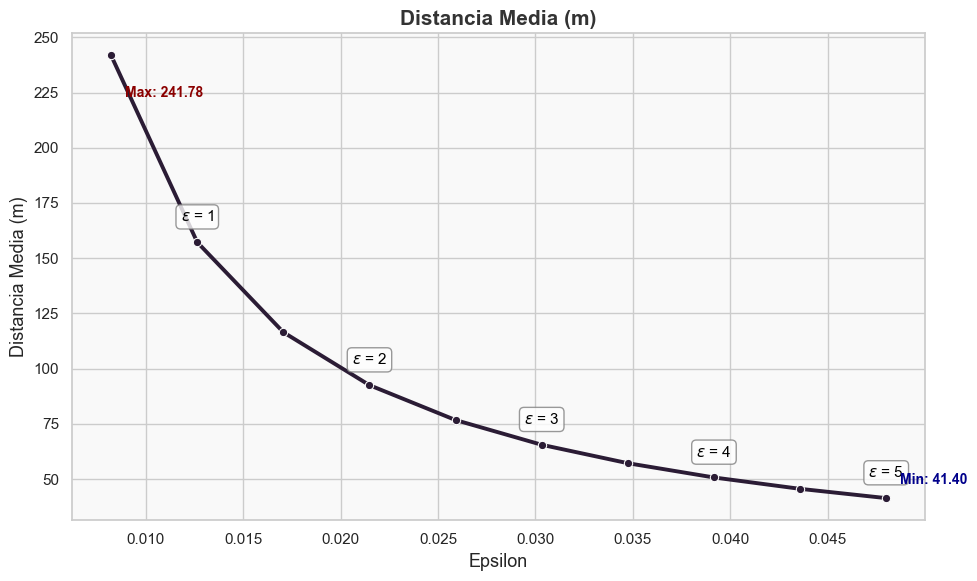


📌 Gráfica de Distancia Máx (m)
Descripción: Mayor distancia registrada entre dos trayectorias.



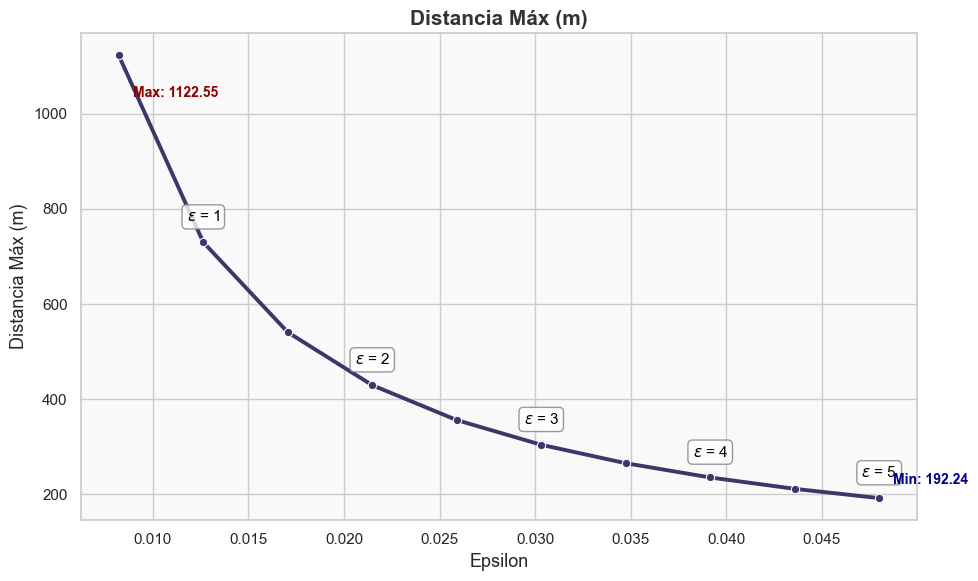


📌 Gráfica de Desv. Estándar (m)
Descripción: Variabilidad de la distancia entre las trayectorias.



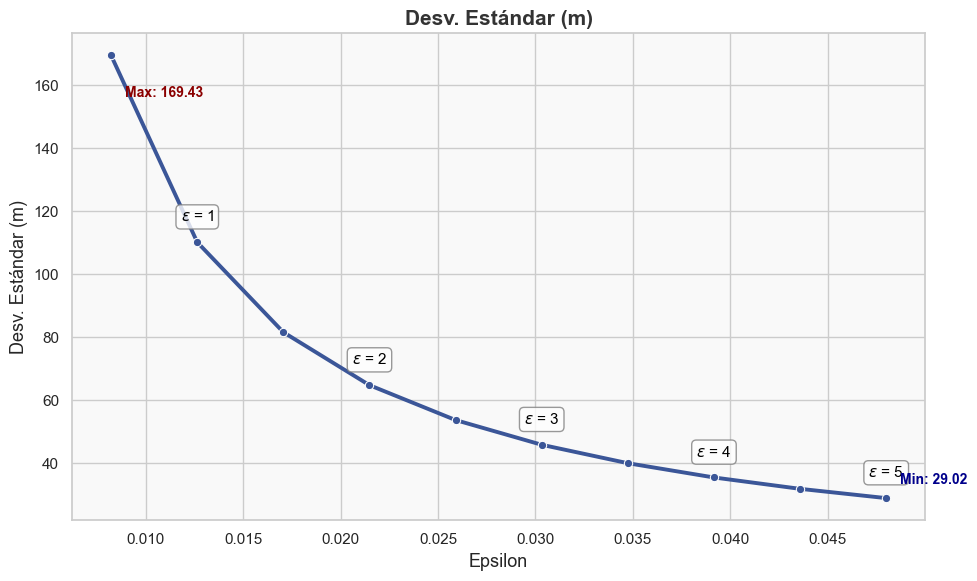


📌 Gráfica de Error Longitud (m)
Descripción: Diferencia en longitud total entre las trayectorias.



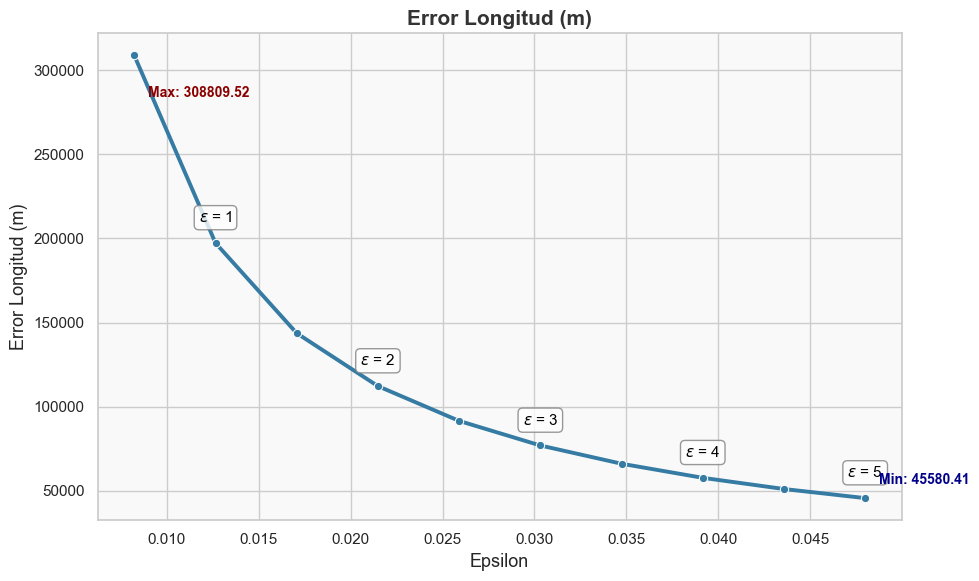


📌 Gráfica de Error Dirección (rad)
Descripción: Diferencia en orientación promedio entre las trayectorias.



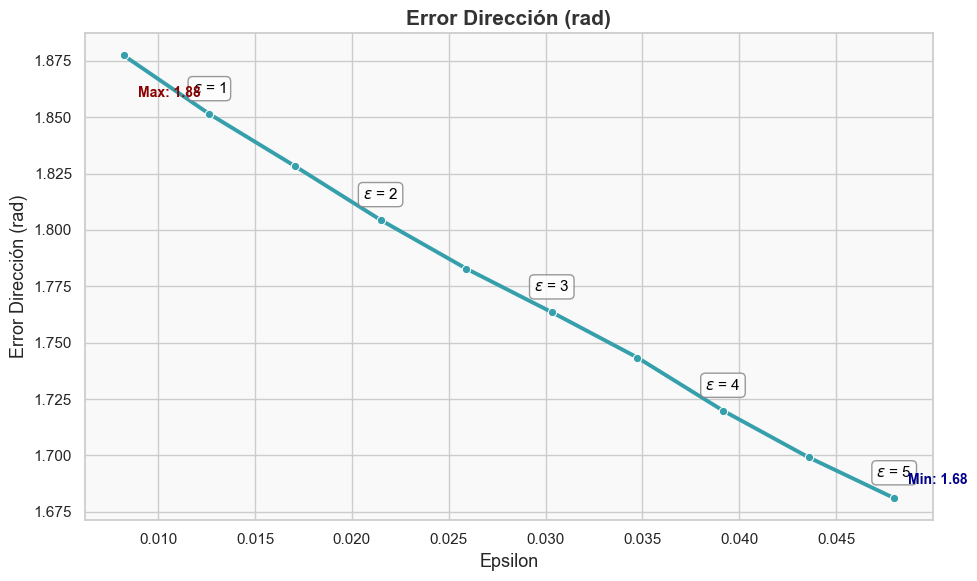


📌 Gráfica de Hausdorff (m)
Descripción: Distancia Hausdorff que mide la similitud entre trayectorias.



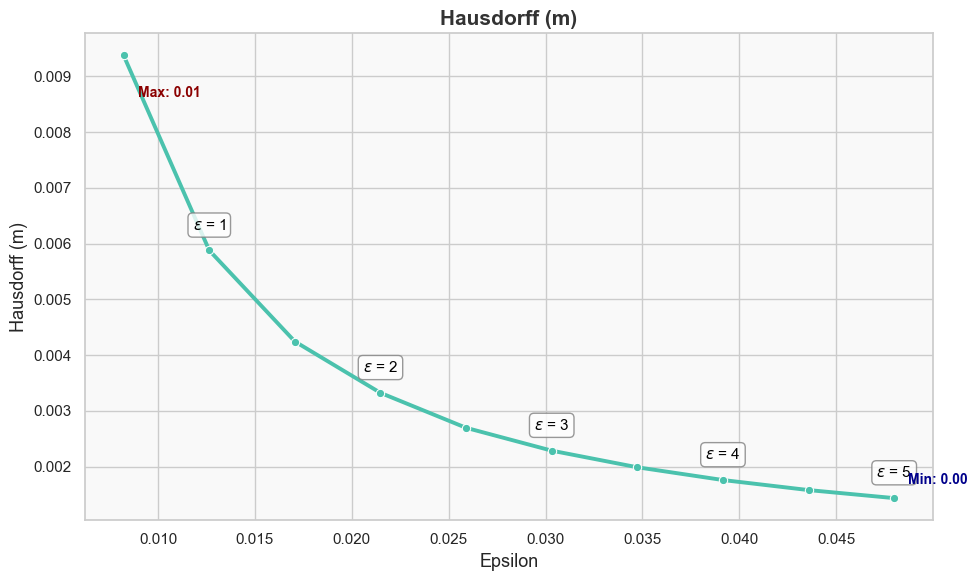


📌 Gráfica de Tiempo (s)
Descripción: Tiempo requerido para el procesamiento.



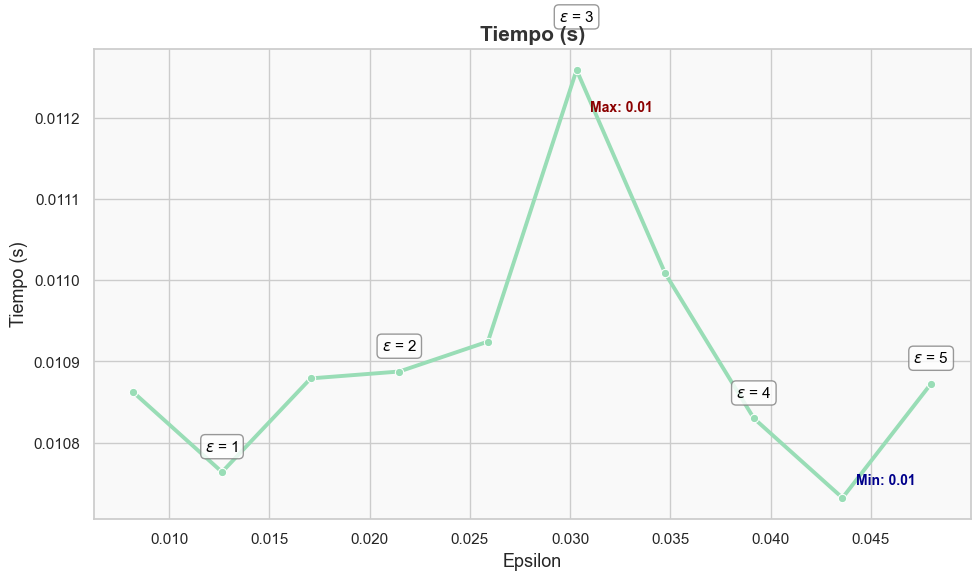

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Leer datos
df = pd.read_csv("laplace_results.csv")

# Agrupar por epsilon y promediar todas las métricas
df_avg = df.groupby("Epsilon", as_index=False).mean(numeric_only=True)

metricas = [
    "Distancia Media (m)",
    "Distancia Máx (m)",
    "Desv. Estándar (m)",
    "Error Longitud (m)",
    "Error Dirección (rad)",
    "Hausdorff (m)",
    "Tiempo (s)"
]

# Descripciones para cada métrica
descripciones = {
    "Distancia Media (m)": "Promedio de la distancia entre trayectorias originales y aproximadas.",
    "Distancia Máx (m)": "Mayor distancia registrada entre dos trayectorias.",
    "Desv. Estándar (m)": "Variabilidad de la distancia entre las trayectorias.",
    "Error Longitud (m)": "Diferencia en longitud total entre las trayectorias.",
    "Error Dirección (rad)": "Diferencia en orientación promedio entre las trayectorias.",
    "Hausdorff (m)": "Distancia Hausdorff que mide la similitud entre trayectorias.",
    "Tiempo (s)": "Tiempo requerido para el procesamiento."
}

sns.set_theme(style="whitegrid")
plt.rcParams.update({'font.size': 13})

palette = sns.color_palette("mako", len(metricas))

# Índices y etiquetas para epsilon
annot_indices = [1, 3, 5, 7, 9]
epsilons_labels = [r'$\epsilon$ = 1', r'$\epsilon$ = 2', r'$\epsilon$ = 3', r'$\epsilon$ = 4', r'$\epsilon$ = 5']

for i, metrica in enumerate(metricas):
    print(f"\n📌 Gráfica de {metrica}")
    print(f"Descripción: {descripciones[metrica]}\n")
    
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=df_avg, x="Epsilon", y=metrica, marker="o", linewidth=2.8, color=palette[i])
    
    ax.set_title(metrica, fontsize=15, fontweight="bold", color="#333333")
    ax.set_xlabel("Epsilon", fontsize=13)
    ax.set_ylabel(metrica, fontsize=13)
    ax.set_facecolor("#f9f9f9")
    
    # Mostrar números completos en el eje Y
    ax.ticklabel_format(style='plain', axis='y')
    
    # Anotaciones de epsilon (solo si hay suficientes puntos)
    for idx, label in zip(annot_indices, epsilons_labels):
        if idx < len(df_avg):
            x = df_avg["Epsilon"].iloc[idx]
            y = df_avg[metrica].iloc[idx]
            offset_y = 15
            if y == df_avg[metrica].max():
                offset_y += 20
            
            ax.annotate(label,
                        xy=(x, y),
                        xytext=(0, offset_y),
                        textcoords="offset points",
                        ha="center",
                        fontsize=11,
                        color="black",
                        bbox=dict(boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.8))
    
    # Anotaciones de máximo y mínimo
    max_val = df_avg[metrica].max()
    min_val = df_avg[metrica].min()
    max_idx = df_avg[metrica].idxmax()
    min_idx = df_avg[metrica].idxmin()
    
    ax.annotate(f"Max: {max_val:.2f}", xy=(df_avg["Epsilon"][max_idx], max_val),
                xytext=(10, -30), textcoords="offset points",
                fontsize=10, color="darkred", fontweight="bold")
    
    ax.annotate(f"Min: {min_val:.2f}", xy=(df_avg["Epsilon"][min_idx], min_val),
                xytext=(10, 10), textcoords="offset points",
                fontsize=10, color="darkblue", fontweight="bold")
    
    plt.tight_layout()
    plt.show()


## Mapas de calor

In [41]:
paso_m = 1000

In [46]:
import numpy as np
from scipy.sparse import dok_matrix
import os
from glob import glob

# ----------------- Funciones auxiliares -----------------
R = 6371000.0  # Radio de la tierra en metros

def cargar_trayectoria(ruta_archivo):
    latlons = []
    with open(ruta_archivo, "r", encoding="utf-8", errors="ignore") as f:
        for i, linea in enumerate(f):
            if i < 6: continue  # Saltar cabecera
            partes = linea.strip().split(",")
            try:
                latlons.append((float(partes[0]), float(partes[1])))
            except (ValueError, IndexError):
                continue
    return np.array(latlons)

def latlon_a_celda(lat, lon, lat_min, lon_min, paso_m):
    """
    Convierte lat/lon a índice de celda, usando límites mínimos y tamaño de celda.
    """
    # Aproximación: 1° lat ~ 111 km
    paso_lat = paso_m / 111000               # metros a grados latitud
    paso_lon = paso_m / (111000 * np.cos(np.radians((lat_min + lat.max())/2)))  # metros a grados longitud
    i = ((lat - lat_min) // paso_lat).astype(int)
    j = ((lon - lon_min) // paso_lon).astype(int)
    return i, j

def obtener_celdas_unificadas(trayectorias, trayectorias_pert, paso_m):
    """
    Obtiene un diccionario con las celdas únicas para todas las trayectorias.
    """
    # Limites globales
    todas_lats = np.concatenate([tray[:,0] for tray in trayectorias + trayectorias_pert])
    todas_lons = np.concatenate([tray[:,1] for tray in trayectorias + trayectorias_pert])
    lat_min, lon_min = todas_lats.min(), todas_lons.min()

    celdas = {}
    idx = 0
    for tray in trayectorias + trayectorias_pert:
        i, j = latlon_a_celda(tray[:,0], tray[:,1], lat_min, lon_min, paso_m)
        for c in zip(i, j):
            if c not in celdas:
                celdas[c] = idx
                idx += 1
    return celdas, lat_min, lon_min

def construir_matriz_od_sparse(trayectorias, celdas, lat_min, lon_min, paso_m):
    n = len(celdas)
    OD = dok_matrix((n, n), dtype=int)  # sparse
    for tray in trayectorias:
        i, j = latlon_a_celda(tray[:,0], tray[:,1], lat_min, lon_min, paso_m)
        origen = celdas[(i[0], j[0])]
        destino = celdas[(i[-1], j[-1])]
        OD[origen, destino] += 1
    return OD

# ----------------- Cargar trayectorias -----------------
ruta_carpeta = "../GeoLife Trajectories 1.3/Data/002/Trajectory2"
archivos_plt = glob(os.path.join(ruta_carpeta, "*.plt"))
trayectorias = [cargar_trayectoria(f) for f in archivos_plt]
trayectorias_xy = []
for tray in trayectorias:
    if len(tray) == 0: continue
    lat0, lon0 = tray[0]
    x, y = latlon_to_local_xy(tray[:,0], tray[:,1], lat0, lon0)
    trayectorias_xy.append(np.column_stack([x, y]))

# ----------------- Aplicar Laplace correctamente -----------------
trayectorias_pert_xy = [mecanismo_laplace_coordenadas(tray, epsilon=0.0048) 
                        for tray in trayectorias_xy]

# ----------------- Volver a lat/lon -----------------
trayectorias_pert_latlon = []
for tray_orig, tray_pert in zip(trayectorias, trayectorias_pert_xy):
    lat0, lon0 = tray_orig[0]
    lat, lon = local_xy_to_latlon(tray_pert[:,0], tray_pert[:,1], lat0, lon0)
    trayectorias_pert_latlon.append(np.column_stack([lat, lon]))
    
# ----------------- Crear celdas unificadas -----------------
celdas_unificadas, lat_min, lon_min = obtener_celdas_unificadas(trayectorias, trayectorias_pert_latlon, paso_m)

# ----------------- Construir matrices OD -----------------
OD_original = construir_matriz_od_sparse(trayectorias, celdas_unificadas, lat_min, lon_min, paso_m)
OD_perturbada = construir_matriz_od_sparse(trayectorias_pert_latlon, celdas_unificadas, lat_min, lon_min, paso_m)
# ----------------- Listas para graficar -----------------
trayectorias_originales_latlon = []  # aquí guardamos todas las trayectorias originales en lat/lon
trayectorias_perturbadas_latlon = []  # aquí guardamos todas las trayectorias perturbadas en lat/lon

for tray_orig in trayectorias:
    if len(tray_orig) > 0:
        trayectorias_originales_latlon.append(tray_orig)

for tray_orig, tray_pert in zip(trayectorias, trayectorias_pert_xy):
    if len(tray_pert) > 0:
        # Convertir coordenadas locales perturbadas a lat/lon
        lat0, lon0 = tray_orig[0]
        lat, lon = local_xy_to_latlon(tray_pert[:,0], tray_pert[:,1], lat0, lon0)
        trayectorias_perturbadas_latlon.append(np.column_stack([lat, lon]))

# Ahora tienes:
# trayectorias_originales_latlon -> lista de arrays (lat, lon) de trayectorias originales
# trayectorias_perturbadas_latlon -> lista de arrays (lat, lon) de trayectorias perturbadas

# ----------------- Información -----------------
print("Número de celdas:", len(celdas_unificadas))
print("Viajes totales originales:", OD_original.sum())
print("Viajes totales perturbados:", OD_perturbada.sum())


Número de celdas: 36
Viajes totales originales: 3
Viajes totales perturbados: 3


In [49]:
import folium

# ---------- MAPA 1: Trayectorias originales ----------
lat_c, lon_c = trayectorias_originales_latlon[0][0]
mapa_original = folium.Map(location=[lat_c, lon_c], zoom_start=12)

for idx, tray in enumerate(trayectorias_originales_latlon):
    coords = [(lat, lon) for lat, lon in tray]

    # Dibujar la trayectoria
    folium.PolyLine(coords, color="blue", weight=2, opacity=0.7).add_to(mapa_original)

    # Marcar inicio (verde)
    folium.CircleMarker(
        location=coords[0],
        radius=4,
        color="green",
        fill=True,
        fill_opacity=1,
        popup=f"Inicio Trayectoria {idx}"
    ).add_to(mapa_original)

    # Marcar fin (rojo)
    folium.CircleMarker(
        location=coords[-1],
        radius=4,
        color="red",
        fill=True,
        fill_opacity=1,
        popup=f"Fin Trayectoria {idx}"
    ).add_to(mapa_original)

mapa_original.save("Laplace_graphs/mapa_trayectorias_originales.html")


# ---------- MAPA 2: Trayectorias perturbadas ----------
lat_c2, lon_c2 = trayectorias_perturbadas_latlon[0][0]
mapa_perturbado = folium.Map(location=[lat_c2, lon_c2], zoom_start=12)

for idx, tray in enumerate(trayectorias_perturbadas_latlon):
    coords = [(lat, lon) for lat, lon in tray]

    # Dibujar la trayectoria
    folium.PolyLine(coords, color="red", weight=2, opacity=0.7).add_to(mapa_perturbado)

    # Marcar inicio (verde)
    folium.CircleMarker(
        location=coords[0],
        radius=4,
        color="green",
        fill=True,
        fill_opacity=1,
        popup=f"Inicio Trayectoria {idx}"
    ).add_to(mapa_perturbado)

    # Marcar fin (black)
    folium.CircleMarker(
        location=coords[-1],
        radius=4,
        color="black",
        fill=True,
        fill_opacity=1,
        popup=f"Fin Trayectoria {idx}"
    ).add_to(mapa_perturbado)

mapa_perturbado.save("Laplace_graphs/mapa_trayectorias_perturbadas.html")

print("✅ Mapas generados con INICIO (verde) y FIN (rojo/negro).")


✅ Mapas generados con INICIO (verde) y FIN (rojo/negro).


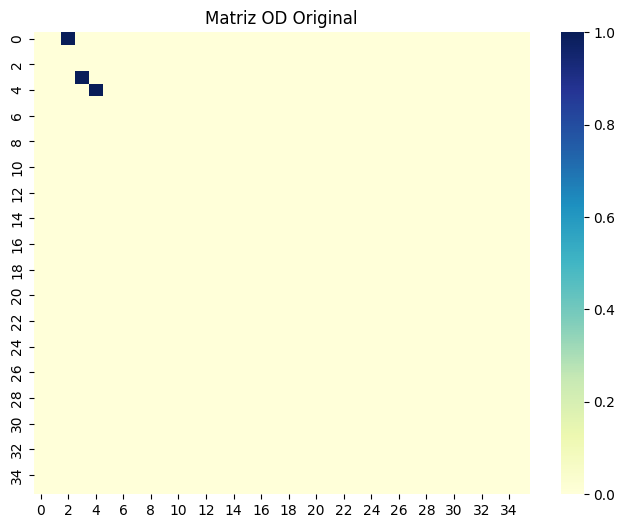

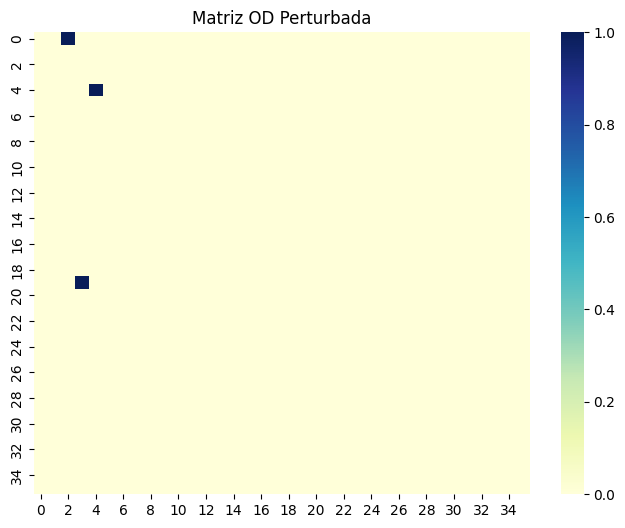

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir a denso solo si no es muy grande
OD_orig_dense = OD_original.todense()
OD_pert_dense = OD_perturbada.todense()

# Heatmap de ejemplo
plt.figure(figsize=(8,6))
sns.heatmap(OD_orig_dense, cmap="YlGnBu", cbar=True)
plt.title("Matriz OD Original")
plt.show()

# Heatmap de ejemplo
plt.figure(figsize=(8,6))
sns.heatmap(OD_pert_dense, cmap="YlGnBu", cbar=True)
plt.title("Matriz OD Perturbada")
plt.show()



# Mapa de calor por zonas mas transitadas

In [21]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt



def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# Cantidad de viajes por celda
viajes_por_celda = np.array([OD_original[i,i] for i in range(len(celdas_unificadas))])

# Crear mapa
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# Crear colormap usando matplotlib 'plasma'
colormap = LinearColormap(
    colors=[plt.cm.plasma(i/255)[:3] for i in range(0,256,5)],  # colores del 0 al 255
    vmin=0,
    vmax=viajes_por_celda.max()
)
colormap.caption = "Número de viajes por celda"
colormap.add_to(m)

# Dibujar celdas
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))
    
    # Color según número de viajes
    intensidad = viajes_por_celda[idx]
    color_hex = colormap(intensidad)
    
    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.7,
        tooltip=f"Zona: {idx}\nViajes: {viajes_por_celda[idx]}"
    ).add_to(m)

# Guardar mapa
m.save("Laplace_graphs/celdas_beijing_original.html")


In [17]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt



def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# Cantidad de viajes por celda
viajes_por_celda = np.array([OD_perturbada[i,i] for i in range(len(celdas_unificadas))])

# Crear mapa
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# Crear colormap usando matplotlib 'plasma'
colormap = LinearColormap(
    colors=[plt.cm.plasma(i/255)[:3] for i in range(0,256,5)],  # colores del 0 al 255
    vmin=0,
    vmax=viajes_por_celda.max()
)
colormap.caption = "Número de viajes por celda"
colormap.add_to(m)

# Dibujar celdas
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))
    
    # Color según número de viajes
    intensidad = viajes_por_celda[idx]
    color_hex = colormap(intensidad)
    
    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.7,
        tooltip=f"Zona: {idx}\nViajes: {viajes_por_celda[idx]}"
    ).add_to(m)

# Guardar mapa
m.save("Laplace_graphs/celdas_beijing_perturbado.html")


# Mapa de calor por destino  

In [51]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt

def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# 🔹 Ahora calculamos los viajes por celda destino (sumando por columnas)
viajes_por_celda = np.array([OD_original[:, i].sum() for i in range(len(celdas_unificadas))])

# Crear mapa centrado en el área
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# Crear colormap usando matplotlib 'plasma'
colormap = LinearColormap(
    colors=[plt.cm.plasma(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda.max()
)
colormap.caption = "Número de viajes con destino en celda"
colormap.add_to(m)

# Dibujar celdas
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))
    
    intensidad = viajes_por_celda[idx]
    color_hex = colormap(intensidad)
    
    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.7,
        tooltip=f"Zona destino: {idx}\nViajes recibidos: {viajes_por_celda[idx]}"
    ).add_to(m)

# Guardar mapa
m.save("Laplace_graphs/celdas_destino_original.html")
# 🔹 Ahora calculamos los viajes por celda destino (sumando por columnas)
viajes_por_celda = np.array([OD_original[:, i].sum() for i in range(len(celdas_unificadas))])

# 🔹 Imprimir en terminal
print("=== VIAJES POR CELDA DESTINO ===")
for idx, num_viajes in enumerate(viajes_por_celda):
    print(f"Celda destino {idx}: {num_viajes} viajes")

print("\nTOTAL de viajes considerados:", viajes_por_celda.sum())

=== VIAJES POR CELDA DESTINO ===
Celda destino 0: 0 viajes
Celda destino 1: 0 viajes
Celda destino 2: 1 viajes
Celda destino 3: 1 viajes
Celda destino 4: 1 viajes
Celda destino 5: 0 viajes
Celda destino 6: 0 viajes
Celda destino 7: 0 viajes
Celda destino 8: 0 viajes
Celda destino 9: 0 viajes
Celda destino 10: 0 viajes
Celda destino 11: 0 viajes
Celda destino 12: 0 viajes
Celda destino 13: 0 viajes
Celda destino 14: 0 viajes
Celda destino 15: 0 viajes
Celda destino 16: 0 viajes
Celda destino 17: 0 viajes
Celda destino 18: 0 viajes
Celda destino 19: 0 viajes
Celda destino 20: 0 viajes
Celda destino 21: 0 viajes
Celda destino 22: 0 viajes
Celda destino 23: 0 viajes
Celda destino 24: 0 viajes
Celda destino 25: 0 viajes
Celda destino 26: 0 viajes
Celda destino 27: 0 viajes
Celda destino 28: 0 viajes
Celda destino 29: 0 viajes
Celda destino 30: 0 viajes
Celda destino 31: 0 viajes
Celda destino 32: 0 viajes
Celda destino 33: 0 viajes
Celda destino 34: 0 viajes
Celda destino 35: 0 viajes

TOTA

In [ ]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt

def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# 🔹 Cantidad de viajes por celda destino (sumando columnas)
viajes_por_celda = np.array([OD_perturbada[:, i].sum() for i in range(len(celdas_unificadas))])

# Imprimir número de viajes por celda y total
print("=== VIAJES POR CELDA DESTINO (PERTURBADA) ===")
for idx, num_viajes in enumerate(viajes_por_celda):
    print(f"Celda destino {idx}: {num_viajes} viajes")
print("TOTAL de viajes considerados:", viajes_por_celda.sum())

# Crear mapa centrado
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# Crear colormap usando matplotlib 'plasma'
colormap = LinearColormap(
    colors=[plt.cm.plasma(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda.max()
)
colormap.caption = "Número de viajes destino por celda (perturbada)"
colormap.add_to(m)

# Dibujar celdas destino
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))
    
    intensidad = viajes_por_celda[idx]
    color_hex = colormap(intensidad)
    
    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.9,
        tooltip=f"Celda destino: {idx}\nViajes recibidos: {intensidad}"
    ).add_to(m)

# Guardar mapa
m.save("Laplace_graphs/celdas_destino_perturbado.html")
# 🔹 Ahora calculamos los viajes por celda destino (sumando por columnas)
viajes_por_celda = np.array([OD_original[:, i].sum() for i in range(len(celdas_unificadas))])

# 🔹 Imprimir en terminal
print("=== VIAJES POR CELDA DESTINO ===")
for idx, num_viajes in enumerate(viajes_por_celda):
    print(f"Celda destino {idx}: {num_viajes} viajes")

print("\nTOTAL de viajes considerados:", viajes_por_celda.sum())

=== VIAJES POR CELDA DESTINO (PERTURBADA) ===
Celda destino 0: 0 viajes
Celda destino 1: 0 viajes
Celda destino 2: 1 viajes
Celda destino 3: 1 viajes
Celda destino 4: 1 viajes
Celda destino 5: 0 viajes
Celda destino 6: 0 viajes
Celda destino 7: 0 viajes
Celda destino 8: 0 viajes
Celda destino 9: 0 viajes
Celda destino 10: 0 viajes
Celda destino 11: 0 viajes
Celda destino 12: 0 viajes
Celda destino 13: 0 viajes
Celda destino 14: 0 viajes
Celda destino 15: 0 viajes
Celda destino 16: 0 viajes
Celda destino 17: 0 viajes
Celda destino 18: 0 viajes
Celda destino 19: 0 viajes
Celda destino 20: 0 viajes
Celda destino 21: 0 viajes
Celda destino 22: 0 viajes
Celda destino 23: 0 viajes
Celda destino 24: 0 viajes
Celda destino 25: 0 viajes
Celda destino 26: 0 viajes
Celda destino 27: 0 viajes
Celda destino 28: 0 viajes
Celda destino 29: 0 viajes
Celda destino 30: 0 viajes
Celda destino 31: 0 viajes
Celda destino 32: 0 viajes
Celda destino 33: 0 viajes
Celda destino 34: 0 viajes
Celda destino 35: 0

# Celdas Origen Mapa de Calor

In [61]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt

def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# 🔹 Cantidad de viajes por celda origen (sumando filas)
viajes_por_celda_origen = np.array([OD_original[i, :].sum() for i in range(len(celdas_unificadas))])

# 🔹 Imprimir en terminal
print("=== VIAJES POR CELDA ORIGEN ===")
for idx, num_viajes in enumerate(viajes_por_celda_origen):
    print(f"Celda origen {idx}: {num_viajes} viajes")
print("\nTOTAL de viajes desde todas las celdas origen:", viajes_por_celda_origen.sum())

# Crear mapa centrado en el área
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# Crear colormap usando matplotlib 'plasma'
colormap = LinearColormap(
    colors=[plt.cm.plasma(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_origen.max()
)
colormap.caption = "Número de viajes desde celda origen"
colormap.add_to(m)

# Dibujar celdas origen
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))
    
    intensidad = viajes_por_celda_origen[idx]
    color_hex = colormap(intensidad)
    
    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.9,
        tooltip=f"Celda origen: {idx}\nViajes enviados: {intensidad}"
    ).add_to(m)

# Guardar mapa
m.save("Laplace_graphs/celdas_origen_original.html")


=== VIAJES POR CELDA ORIGEN ===
Celda origen 0: 1 viajes
Celda origen 1: 0 viajes
Celda origen 2: 0 viajes
Celda origen 3: 1 viajes
Celda origen 4: 1 viajes
Celda origen 5: 0 viajes
Celda origen 6: 0 viajes
Celda origen 7: 0 viajes
Celda origen 8: 0 viajes
Celda origen 9: 0 viajes
Celda origen 10: 0 viajes
Celda origen 11: 0 viajes
Celda origen 12: 0 viajes
Celda origen 13: 0 viajes
Celda origen 14: 0 viajes
Celda origen 15: 0 viajes
Celda origen 16: 0 viajes
Celda origen 17: 0 viajes
Celda origen 18: 0 viajes
Celda origen 19: 0 viajes
Celda origen 20: 0 viajes
Celda origen 21: 0 viajes
Celda origen 22: 0 viajes
Celda origen 23: 0 viajes
Celda origen 24: 0 viajes
Celda origen 25: 0 viajes
Celda origen 26: 0 viajes
Celda origen 27: 0 viajes
Celda origen 28: 0 viajes
Celda origen 29: 0 viajes
Celda origen 30: 0 viajes
Celda origen 31: 0 viajes
Celda origen 32: 0 viajes
Celda origen 33: 0 viajes
Celda origen 34: 0 viajes
Celda origen 35: 0 viajes

TOTAL de viajes desde todas las celdas or

In [54]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt

def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# 🔹 Cantidad de viajes por celda origen (sumando filas)
viajes_por_celda_origen = np.array([OD_perturbada[i, :].sum() for i in range(len(celdas_unificadas))])

# 🔹 Imprimir número de viajes por celda origen y total
print("=== VIAJES POR CELDA ORIGEN (PERTURBADA) ===")
for idx, num_viajes in enumerate(viajes_por_celda_origen):
    print(f"Celda origen {idx}: {num_viajes} viajes")
print("TOTAL de viajes desde todas las celdas origen:", viajes_por_celda_origen.sum())

# Crear mapa centrado
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# Crear colormap usando matplotlib 'plasma'
colormap = LinearColormap(
    colors=[plt.cm.plasma(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_origen.max()
)
colormap.caption = "Número de viajes desde celda origen (perturbada)"
colormap.add_to(m)

# Dibujar celdas origen
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))
    
    intensidad = viajes_por_celda_origen[idx]
    color_hex = colormap(intensidad)
    
    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_hex,
        fill=True,
        fill_color=color_hex,
        fill_opacity=0.7,
        tooltip=f"Celda origen: {idx}\nViajes enviados: {intensidad}"
    ).add_to(m)

# Guardar mapa
m.save("Laplace_graphs/celdas_origen_perturbado.html")


=== VIAJES POR CELDA ORIGEN (PERTURBADA) ===
Celda origen 0: 1 viajes
Celda origen 1: 0 viajes
Celda origen 2: 0 viajes
Celda origen 3: 0 viajes
Celda origen 4: 1 viajes
Celda origen 5: 0 viajes
Celda origen 6: 0 viajes
Celda origen 7: 0 viajes
Celda origen 8: 0 viajes
Celda origen 9: 0 viajes
Celda origen 10: 0 viajes
Celda origen 11: 0 viajes
Celda origen 12: 0 viajes
Celda origen 13: 0 viajes
Celda origen 14: 0 viajes
Celda origen 15: 0 viajes
Celda origen 16: 0 viajes
Celda origen 17: 0 viajes
Celda origen 18: 0 viajes
Celda origen 19: 1 viajes
Celda origen 20: 0 viajes
Celda origen 21: 0 viajes
Celda origen 22: 0 viajes
Celda origen 23: 0 viajes
Celda origen 24: 0 viajes
Celda origen 25: 0 viajes
Celda origen 26: 0 viajes
Celda origen 27: 0 viajes
Celda origen 28: 0 viajes
Celda origen 29: 0 viajes
Celda origen 30: 0 viajes
Celda origen 31: 0 viajes
Celda origen 32: 0 viajes
Celda origen 33: 0 viajes
Celda origen 34: 0 viajes
Celda origen 35: 0 viajes
TOTAL de viajes desde todas l

# Mapa con trayectorias

In [55]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt

def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# 🔹 Convertir sparse matrix a numpy array
OD_array = OD_original.toarray()

# 🔹 Viajes por celda origen y destino
viajes_por_celda_origen = np.array([OD_array[i, :].sum() for i in range(len(celdas_unificadas))])
viajes_por_celda_destino = np.array([OD_array[:, j].sum() for j in range(len(celdas_unificadas))])

# 🔹 Crear mapa centrado
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# 🔹 Colormaps
colormap_origen = LinearColormap(
    colors=[plt.cm.Blues(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_origen.max()
)
colormap_origen.caption = "Viajes desde celda origen"
colormap_origen.add_to(m)

colormap_destino = LinearColormap(
    colors=[plt.cm.Reds(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_destino.max()
)
colormap_destino.caption = "Viajes hacia celda destino"
colormap_destino.add_to(m)

# 🔹 Dibujar celdas origen
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))

    intensidad_origen = viajes_por_celda_origen[idx]
    color_origen = colormap_origen(intensidad_origen)

    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_origen,
        fill=True,
        fill_color=color_origen,
        fill_opacity=0.6,
        tooltip=f"Celda origen: {idx}\nViajes enviados: {intensidad_origen}"
    ).add_to(m)

# 🔹 Dibujar celdas destino
# 🔹 Dibujar celdas con info de origen y destino
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))

    intensidad_origen = viajes_por_celda_origen[idx]
    intensidad_destino = viajes_por_celda_destino[idx]

    # Color combinado (puedes elegir la media de ambos colores)
    color_origen = colormap_origen(intensidad_origen)
    color_destino = colormap_destino(intensidad_destino)
    # Aquí hacemos un color "promedio" visual simple mezclando ambos (aprox)
    color_combinado = f'#{int((int(color_origen[1:3],16)+int(color_destino[1:3],16))/2):02x}' \
                      f'{int((int(color_origen[3:5],16)+int(color_destino[3:5],16))/2):02x}' \
                      f'{int((int(color_origen[5:7],16)+int(color_destino[5:7],16))/2):02x}'

    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_combinado,
        fill=True,
        fill_color=color_combinado,
        fill_opacity=0.6,
        tooltip=(f"Celda: {idx}\n"
                 f"Viajes enviados: {intensidad_origen}\n"
                 f"Viajes recibidos: {intensidad_destino}")
    ).add_to(m)


# 🔹 Dibujar líneas desde origen a destino
max_viajes = OD_array.max()  # para normalizar el grosor
for i in range(len(celdas_unificadas)):
    for j in range(len(celdas_unificadas)):
        if OD_array[i, j] > 0:
            lat_i, lon_i = celda_a_latlon_centro(*list(celdas_unificadas.keys())[i], lat_min, lon_min, paso_m)
            lat_j, lon_j = celda_a_latlon_centro(*list(celdas_unificadas.keys())[j], lat_min, lon_min, paso_m)
            folium.PolyLine(
                locations=[[lat_i, lon_i], [lat_j, lon_j]],
                color='gray',
                weight=OD_array[i,j]/max_viajes*5,  # grosor proporcional
                opacity = 0.7 + 0.3 * (OD_array[i,j] / max_viajes)

            ).add_to(m)

# 🔹 Guardar mapa
m.save("Laplace_graphs/celdas_origen_destino.html")

print("Mapa generado: 'celdas_origen_destino.html' ✅")


Mapa generado: 'celdas_origen_destino.html' ✅


In [60]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt

def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# 🔹 Convertir sparse matrix a numpy array
OD_array = OD_perturbada.toarray()

# 🔹 Viajes por celda origen y destino
viajes_por_celda_origen = np.array([OD_array[i, :].sum() for i in range(len(celdas_unificadas))])
viajes_por_celda_destino = np.array([OD_array[:, j].sum() for j in range(len(celdas_unificadas))])

# 🔹 Crear mapa centrado
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# 🔹 Colormaps
colormap_origen = LinearColormap(
    colors=[plt.cm.Blues(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_origen.max()
)
colormap_origen.caption = "Viajes desde celda origen"
colormap_origen.add_to(m)

colormap_destino = LinearColormap(
    colors=[plt.cm.Reds(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_destino.max()
)
colormap_destino.caption = "Viajes hacia celda destino"
colormap_destino.add_to(m)

# 🔹 Dibujar celdas origen
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))

    intensidad_origen = viajes_por_celda_origen[idx]
    color_origen = colormap_origen(intensidad_origen)

    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_origen,
        fill=True,
        fill_color=color_origen,
        fill_opacity=0.6,
        tooltip=f"Celda origen: {idx}\nViajes enviados: {intensidad_origen}"
    ).add_to(m)

# 🔹 Dibujar celdas destino
# 🔹 Dibujar celdas con info de origen y destino
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))

    intensidad_origen = viajes_por_celda_origen[idx]
    intensidad_destino = viajes_por_celda_destino[idx]

    # Color combinado (puedes elegir la media de ambos colores)
    color_origen = colormap_origen(intensidad_origen)
    color_destino = colormap_destino(intensidad_destino)
    # Aquí hacemos un color "promedio" visual simple mezclando ambos (aprox)
    color_combinado = f'#{int((int(color_origen[1:3],16)+int(color_destino[1:3],16))/2):02x}' \
                      f'{int((int(color_origen[3:5],16)+int(color_destino[3:5],16))/2):02x}' \
                      f'{int((int(color_origen[5:7],16)+int(color_destino[5:7],16))/2):02x}'

    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_combinado,
        fill=True,
        fill_color=color_combinado,
        fill_opacity=0.6,
        tooltip=(f"Celda: {idx}\n"
                 f"Viajes enviados: {intensidad_origen}\n"
                 f"Viajes recibidos: {intensidad_destino}")
    ).add_to(m)


# 🔹 Dibujar líneas desde origen a destino
max_viajes = OD_array.max()  # para normalizar el grosor
for i in range(len(celdas_unificadas)):
    for j in range(len(celdas_unificadas)):
        if OD_array[i, j] > 0:
            lat_i, lon_i = celda_a_latlon_centro(*list(celdas_unificadas.keys())[i], lat_min, lon_min, paso_m)
            lat_j, lon_j = celda_a_latlon_centro(*list(celdas_unificadas.keys())[j], lat_min, lon_min, paso_m)
            folium.PolyLine(
                locations=[[lat_i, lon_i], [lat_j, lon_j]],
                color='gray',
                weight=OD_array[i,j]/max_viajes*5,  # grosor proporcional
                opacity = 0.7 + 0.3 * (OD_array[i,j] / max_viajes)

            ).add_to(m)

# 🔹 Guardar mapa
m.save("Laplace_graphs/celdas_origen_destino_perturbada.html")

print("Mapa generado: 'celdas_origen_destino_perturbada.html' ✅")


Mapa generado: 'celdas_origen_destino_perturbada.html' ✅


In [27]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Función para obtener el centro de la celda
def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# 🔹 Convertir sparse matrix a numpy array
OD_array = OD_original.toarray()

# 🔹 Viajes por celda origen y destino
viajes_por_celda_origen = np.array([OD_array[i, :].sum() for i in range(len(celdas_unificadas))])
viajes_por_celda_destino = np.array([OD_array[:, j].sum() for j in range(len(celdas_unificadas))])

# 🔹 Crear mapa centrado
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# 🔹 Colormaps
colormap_origen = LinearColormap(
    colors=[plt.cm.Blues(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_origen.max()
)
colormap_origen.caption = "Viajes desde celda origen"
colormap_origen.add_to(m)

colormap_destino = LinearColormap(
    colors=[plt.cm.Reds(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_destino.max()
)
colormap_destino.caption = "Viajes hacia celda destino"
colormap_destino.add_to(m)

# 🔹 Dibujar celdas con info de origen y destino
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))

    intensidad_origen = viajes_por_celda_origen[idx]
    intensidad_destino = viajes_por_celda_destino[idx]

    # Color combinado (aproximación)
    color_origen = colormap_origen(intensidad_origen)
    color_destino = colormap_destino(intensidad_destino)
    color_combinado = f'#{int((int(color_origen[1:3],16)+int(color_destino[1:3],16))/2):02x}' \
                      f'{int((int(color_origen[3:5],16)+int(color_destino[3:5],16))/2):02x}' \
                      f'{int((int(color_origen[5:7],16)+int(color_destino[5:7],16))/2):02x}'

    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_combinado,
        fill=True,
        fill_color=color_combinado,
        fill_opacity=0.6,
        tooltip=(f"Celda: {idx}\n"
                 f"Viajes enviados: {intensidad_origen}\n"
                 f"Viajes recibidos: {intensidad_destino}")
    ).add_to(m)

# 🔹 Dibujar líneas con dirección
max_viajes = OD_array.max()  # para normalizar grosor
for i in range(len(celdas_unificadas)):
    for j in range(len(celdas_unificadas)):
        if OD_array[i, j] > 0:
            lat_i, lon_i = celda_a_latlon_centro(*list(celdas_unificadas.keys())[i], lat_min, lon_min, paso_m)
            lat_j, lon_j = celda_a_latlon_centro(*list(celdas_unificadas.keys())[j], lat_min, lon_min, paso_m)
            
            # Línea proporcional a viajes
            linea = folium.PolyLine(
                locations=[[lat_i, lon_i], [lat_j, lon_j]],
                color='gray',
                weight=OD_array[i,j]/max_viajes*5,
                opacity = 0.7 + 0.3 * (OD_array[i,j] / max_viajes)
            ).add_to(m)
            
            # Flecha indicando dirección
            plugins.PolyLineTextPath(
                linea,
                '➤',  # símbolo de flecha
                repeat=True,
                offset=6,
                attributes={'fill': 'black', 'font-weight': 'bold', 'font-size': '12'}
            ).add_to(m)

# 🔹 Guardar mapa
m.save("Laplace_graphs/celdas_origen_destino_flujo.html")

print("Mapa generado: 'celdas_origen_destino_flujo.html' ✅")


Mapa generado: 'celdas_origen_destino_flujo.html' ✅


In [29]:
import folium
from folium import plugins
from branca.colormap import LinearColormap
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Función para obtener el centro de la celda
def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# 🔹 Convertir sparse matrix a numpy array
OD_array = OD_original.toarray()

# 🔹 Viajes por celda origen y destino
viajes_por_celda_origen = np.array([OD_array[i, :].sum() for i in range(len(celdas_unificadas))])
viajes_por_celda_destino = np.array([OD_array[:, j].sum() for j in range(len(celdas_unificadas))])

# 🔹 Crear mapa centrado
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# 🔹 Colormaps
colormap_origen = LinearColormap(
    colors=[plt.cm.Blues(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_origen.max()
)
colormap_origen.caption = "Viajes desde celda origen"
colormap_origen.add_to(m)

colormap_destino = LinearColormap(
    colors=[plt.cm.Reds(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_destino.max()
)
colormap_destino.caption = "Viajes hacia celda destino"
colormap_destino.add_to(m)

# 🔹 Dibujar celdas con info de origen y destino
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))

    intensidad_origen = viajes_por_celda_origen[idx]
    intensidad_destino = viajes_por_celda_destino[idx]

    # Color combinado (aproximación)
    color_origen = colormap_origen(intensidad_origen)
    color_destino = colormap_destino(intensidad_destino)
    color_combinado = f'#{int((int(color_origen[1:3],16)+int(color_destino[1:3],16))/2):02x}' \
                      f'{int((int(color_origen[3:5],16)+int(color_destino[3:5],16))/2):02x}' \
                      f'{int((int(color_origen[5:7],16)+int(color_destino[5:7],16))/2):02x}'

    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color=color_combinado,
        fill=True,
        fill_color=color_combinado,
        fill_opacity=0.6,
        tooltip=(f"Celda: {idx}\n"
                 f"Viajes enviados: {intensidad_origen}\n"
                 f"Viajes recibidos: {intensidad_destino}")
    ).add_to(m)

# 🔹 Dibujar líneas animadas (AntPath) con dirección
# 🔹 Dibujar líneas animadas (AntPath) con dirección
max_viajes = OD_array.max()  # para normalizar grosor
for i in range(len(celdas_unificadas)):
    for j in range(len(celdas_unificadas)):
        if OD_array[i, j] > 0:
            lat_i, lon_i = celda_a_latlon_centro(*list(celdas_unificadas.keys())[i], lat_min, lon_min, paso_m)
            lat_j, lon_j = celda_a_latlon_centro(*list(celdas_unificadas.keys())[j], lat_min, lon_min, paso_m)
            
            # Grosor proporcional con mínimo más grueso
            weight = 2 + (OD_array[i,j]/max_viajes*5)  # mínimo 2, máximo 7 aprox.
            
            plugins.AntPath(
                locations=[[lat_i, lon_i], [lat_j, lon_j]],
                dash_array=[10, 20],
                delay=1000,
                color='blue',
                pulse_color='white',
                weight=weight
            ).add_to(m)


# 🔹 Guardar mapa
m.save("Laplace_graphs/celdas_origen_destino_animado.html")

print("Mapa generado: 'celdas_origen_destino_animado.html' ✅")


Mapa generado: 'celdas_origen_destino_animado.html' ✅


# Graficas animadas interactivas

In [58]:
import folium
from folium import plugins
from branca.colormap import LinearColormap, linear
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Función para obtener el centro de la celda
def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# 🔹 Convertir sparse matrix a numpy array
OD_array = OD_original.toarray()

# 🔹 Viajes por celda origen y destino
viajes_por_celda_origen = np.array([OD_array[i, :].sum() for i in range(len(celdas_unificadas))])
viajes_por_celda_destino = np.array([OD_array[:, j].sum() for j in range(len(celdas_unificadas))])

# 🔹 Crear mapa centrado
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# 🔹 Colormaps para celdas
colormap_origen = LinearColormap(
    colors=[plt.cm.Blues(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_origen.max()
)
colormap_origen.caption = "Viajes desde celda origen"
colormap_origen.add_to(m)

colormap_destino = LinearColormap(
    colors=[plt.cm.Reds(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_destino.max()
)
colormap_destino.caption = "Viajes hacia celda destino"
colormap_destino.add_to(m)

# 🔹 Dibujar celdas con info de origen y destino (totales)
# 🔹 Dibujar celdas con info de origen y destino (totales + detalle de viajes recibidos)
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))

    intensidad_origen = viajes_por_celda_origen[idx]
    intensidad_destino = viajes_por_celda_destino[idx]

    # Color combinado aproximado
    color_origen = colormap_origen(intensidad_origen)
    color_destino = colormap_destino(intensidad_destino)
    color_combinado = f'#{int((int(color_origen[1:3],16)+int(color_destino[1:3],16))/2):02x}' \
                      f'{int((int(color_origen[3:5],16)+int(color_destino[3:5],16))/2):02x}' \
                      f'{int((int(color_origen[5:7],16)+int(color_destino[5:7],16))/2):02x}'

    # 🔹 Detalle de los orígenes de los viajes recibidos
    detalle_origenes = ""
    for origen, cantidad in enumerate(OD_array[:, idx]):
        if cantidad > 0:
            if origen == idx:
                detalle_origenes += f" → Desde esta misma celda: {cantidad} viaje(s)<br>"
            else:
                detalle_origenes += f" → Desde celda {origen}: {cantidad} viaje(s)<br>"

    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color='black',               
        weight=1,
        fill=True,
        fill_color=color_combinado,
        fill_opacity=0.5,            
        tooltip=(f"<b>Celda {idx}</b><br>"
                 f"Total viajes enviados desde esta celda: {intensidad_origen}<br>"
                 f"Total viajes recibidos en esta celda: {intensidad_destino}<br>"
                 f"<b>Detalle viajes recibidos:</b><br>"
                 f"{detalle_origenes}")
    ).add_to(m)


# 🔹 Dibujar líneas animadas (AntPath) mostrando solo viajes origen→destino
max_viajes = OD_array.max()
for i in range(len(celdas_unificadas)):
    for j in range(len(celdas_unificadas)):
        if OD_array[i, j] > 0:
            lat_i, lon_i = celda_a_latlon_centro(*list(celdas_unificadas.keys())[i], lat_min, lon_min, paso_m)
            lat_j, lon_j = celda_a_latlon_centro(*list(celdas_unificadas.keys())[j], lat_min, lon_min, paso_m)
            
            # Grosor proporcional con mínimo más grueso
            weight = 2 + (OD_array[i,j]/max_viajes*5)
            
            # Color degradado azul→rojo según intensidad de la línea
            color_line = f"rgba({int(255 * (1 - OD_array[i,j]/max_viajes))},0,{int(255 * (OD_array[i,j]/max_viajes))},1)"
            
            plugins.AntPath(
                locations=[[lat_i, lon_i], [lat_j, lon_j]],
                dash_array=[10, 20],
                delay=700,                  # animación rápida
                color=color_line,           # degradado
                pulse_color='white',
                weight=weight,
                tooltip=(f"Viajes desde celda {i} a celda {j}: {OD_array[i,j]}")
            ).add_to(m)

# 🔹 Guardar mapa
m.save("Laplace_graphs/celdas_origen_destino_tooltips_claros.html")
print("Mapa generado: 'celdas_origen_destino_tooltips_claros.html' ✅")


Mapa generado: 'celdas_origen_destino_tooltips_claros.html' ✅


In [59]:
import folium
from folium import plugins
from branca.colormap import LinearColormap, linear
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Función para obtener el centro de la celda
def celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m):
    paso_lat = paso_m / 111000
    paso_lon = (paso_m / (111000 * np.cos(np.radians(lat_min))))
    lat_centro = lat_min + (i + 0.5) * paso_lat
    lon_centro = lon_min + (j + 0.5) * paso_lon
    return lat_centro, lon_centro

# 🔹 Convertir sparse matrix a numpy array
OD_array = OD_perturbada.toarray()

# 🔹 Viajes por celda origen y destino
viajes_por_celda_origen = np.array([OD_array[i, :].sum() for i in range(len(celdas_unificadas))])
viajes_por_celda_destino = np.array([OD_array[:, j].sum() for j in range(len(celdas_unificadas))])

# 🔹 Crear mapa centrado
lat_centro = np.mean([lat_min, np.max(np.concatenate([tray[:,0] for tray in trayectorias]))])
lon_centro = np.mean([lon_min, np.max(np.concatenate([tray[:,1] for tray in trayectorias]))])
m = folium.Map(location=[lat_centro, lon_centro], zoom_start=12, tiles="CartoDB positron")

# 🔹 Colormaps para celdas
colormap_origen = LinearColormap(
    colors=[plt.cm.Blues(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_origen.max()
)
colormap_origen.caption = "Viajes desde celda origen"
colormap_origen.add_to(m)

colormap_destino = LinearColormap(
    colors=[plt.cm.Reds(i/255)[:3] for i in range(0,256,5)],
    vmin=0,
    vmax=viajes_por_celda_destino.max()
)
colormap_destino.caption = "Viajes hacia celda destino"
colormap_destino.add_to(m)

# 🔹 Dibujar celdas con info de origen y destino (totales)
# 🔹 Dibujar celdas con info de origen y destino (totales + detalle de viajes recibidos)
for (i, j), idx in celdas_unificadas.items():
    lat_c, lon_c = celda_a_latlon_centro(i, j, lat_min, lon_min, paso_m)
    radio_lat = (paso_m / 2) / 111000
    radio_lon = (paso_m / 2) / (111000 * np.cos(np.radians(lat_c)))

    intensidad_origen = viajes_por_celda_origen[idx]
    intensidad_destino = viajes_por_celda_destino[idx]

    # Color combinado aproximado
    color_origen = colormap_origen(intensidad_origen)
    color_destino = colormap_destino(intensidad_destino)
    color_combinado = f'#{int((int(color_origen[1:3],16)+int(color_destino[1:3],16))/2):02x}' \
                      f'{int((int(color_origen[3:5],16)+int(color_destino[3:5],16))/2):02x}' \
                      f'{int((int(color_origen[5:7],16)+int(color_destino[5:7],16))/2):02x}'

    # 🔹 Detalle de los orígenes de los viajes recibidos
    detalle_origenes = ""
    for origen, cantidad in enumerate(OD_array[:, idx]):
        if cantidad > 0:
            if origen == idx:
                detalle_origenes += f" → Desde esta misma celda: {cantidad} viaje(s)<br>"
            else:
                detalle_origenes += f" → Desde celda {origen}: {cantidad} viaje(s)<br>"

    folium.Rectangle(
        bounds=[[lat_c - radio_lat, lon_c - radio_lon],
                [lat_c + radio_lat, lon_c + radio_lon]],
        color='black',               
        weight=1,
        fill=True,
        fill_color=color_combinado,
        fill_opacity=0.5,            
        tooltip=(f"<b>Celda {idx}</b><br>"
                 f"Total viajes enviados desde esta celda: {intensidad_origen}<br>"
                 f"Total viajes recibidos en esta celda: {intensidad_destino}<br>"
                 f"<b>Detalle viajes recibidos:</b><br>"
                 f"{detalle_origenes}")
    ).add_to(m)


# 🔹 Dibujar líneas animadas (AntPath) mostrando solo viajes origen→destino
max_viajes = OD_array.max()
for i in range(len(celdas_unificadas)):
    for j in range(len(celdas_unificadas)):
        if OD_array[i, j] > 0:
            lat_i, lon_i = celda_a_latlon_centro(*list(celdas_unificadas.keys())[i], lat_min, lon_min, paso_m)
            lat_j, lon_j = celda_a_latlon_centro(*list(celdas_unificadas.keys())[j], lat_min, lon_min, paso_m)
            
            # Grosor proporcional con mínimo más grueso
            weight = 2 + (OD_array[i,j]/max_viajes*5)
            
            # Color degradado azul→rojo según intensidad de la línea
            color_line = f"rgba({int(255 * (1 - OD_array[i,j]/max_viajes))},0,{int(255 * (OD_array[i,j]/max_viajes))},1)"
            
            plugins.AntPath(
                locations=[[lat_i, lon_i], [lat_j, lon_j]],
                dash_array=[10, 20],
                delay=700,                  # animación rápida
                color=color_line,           # degradado
                pulse_color='white',
                weight=weight,
                tooltip=(f"Viajes desde celda {i} a celda {j}: {OD_array[i,j]}")
            ).add_to(m)

# 🔹 Guardar mapa
m.save("Laplace_graphs/celdas_origen_destino_tooltips_claros_perturbada.html")
print("Mapa generado: 'celdas_origen_destino_tooltips_perturbada.html' ✅")


Mapa generado: 'celdas_origen_destino_tooltips_perturbada.html' ✅
